# Initialization

### Loading the required Libraries for Time-Series Analysis

In [0]:
%pip install FBProphet

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import logging
logging.getLogger('py4j').setLevel(logging.ERROR)

### Loading the data

In [0]:
path = "dbfs:/FileStore/tables/"

In [0]:
df = spark.read.format('parquet').load(path)

In [0]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Speed: double (nullable = true)
 |-- TravelTime: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- timedate: timestamp (nullable = true)
 |-- LinkId: integer (nullable = true)
 |-- LinkPoints: string (nullable = true)
 |-- EncodedLinkPoints: string (nullable = true)
 |-- EncodedPolyLineLvls: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- TranscomId: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Link_Name: string (nullable = true)



In [0]:
df = df.withColumnRenamed("Speed", "y")
df = df.withColumnRenamed("timedate", "ds")
df = df.withColumnRenamed("LinkId", "link_id")

In [0]:
from pyspark.sql.types import StringType
df = df.withColumn("link_id",df.link_id.cast('string'))

In [0]:
df = df.select('ds', 'link_id', 'y')

In [0]:
from pyspark.sql.functions import count, col

# Filtering link points with atleast 200,000 records.
list = df.groupBy('link_id').agg(count('link_id').alias('records')).filter(col('records')>200000).select('link_id')

#storing these Link Points to a list 
list = list.toPandas().link_id.tolist()

#specifying filters to clean the data
cleaning_filters = ( df.link_id.isin(list) ) & (df.ds >= '2018-01-01') & (df.ds < '2022-01-01') & (df.y < 68) & (df.y > 0)

In [0]:
# Filtering rows to clean the data
df = df.filter( cleaning_filters )

df = df.select('ds', 'y')

In [0]:
# Due to memory and compute limitations of Databricks
from pyspark.sql.functions import date_trunc
from pyspark.sql.functions import avg

df = df.select( date_trunc('hour', df.ds).alias('ds'), 'y').groupBy('ds').agg(avg('y').alias('y'))

In [0]:
df.printSchema()
df.show(10)

root
 |-- ds: timestamp (nullable = true)
 |-- y: double (nullable = true)

+-------------------+------------------+
|                 ds|                 y|
+-------------------+------------------+
|2021-12-13 16:00:00| 38.61709019607842|
|2019-08-28 14:00:00| 35.51165832737665|
|2019-09-14 23:00:00|26.133981831945487|
|2019-09-26 04:00:00|43.716269153897244|
|2019-09-08 19:00:00| 35.00745014245018|
|2019-09-11 10:00:00| 35.50556221889063|
|2019-06-18 00:00:00|40.998686868686825|
|2019-11-15 04:00:00| 42.27182519280206|
|2019-07-03 21:00:00|24.861240000000084|
|2019-09-02 22:00:00| 42.11404040404024|
+-------------------+------------------+
only showing top 10 rows



In [0]:
df.createOrReplaceTempView('data')

# Time-Seriers Analysis | Entire Dataset
**NOTE: [This model is trained by averaging the data for all Link Points over the hours, in order to run it properly in Databricks. The results of running it on entire dataset without aggregation are somewhat indicative but noticably different, and are included as exported HTML file within the submission.]**

## Training Time-Series Model with Cross-Validation and Hyperparameter Tuning

In [0]:
# Preparing input for training model. The testing will be performed by Cross Validation over 180 days time-interval (4years/180days = 8-Fold CV).

df = df.toPandas()

In [0]:
df

,ds,y
0,2021-12-13 16:00:00,38.617090
1,2019-08-28 14:00:00,35.511658
2,2019-09-14 23:00:00,26.133982
3,2019-09-26 04:00:00,43.716269
4,2019-09-08 19:00:00,35.007450
...,...,...
34320,2018-05-29 09:00:00,48.106755
34321,2018-05-29 02:00:00,44.787453
34322,2018-05-31 18:00:00,30.674927
34323,2018-05-27 02:00:00,40.173210


In [0]:
import itertools
import numpy as np
import pandas as pd
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05, 0.10],
    'seasonality_prior_scale': [0.01, 0.02],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
models = []  # Store the models for each params here
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='180 days', parallel="threads")
    df_p = performance_metrics(df_cv, rolling_window=1)
    models.append(m)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 23:00:00 and 2021-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f8c0d86cfd0>
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 23:00:00 and 2021-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f8c38d1c790>
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 23:00:00 and 2021-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f8c38d92400>
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 23:00:00 and 2021-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f8c10bb4a90>
INFO:prophet:Making 9 forecasts with cutoffs between 2019-07-15 23:00:00 and 2021-07-04 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.Threa

In [0]:
print(tuning_results)

   changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.01                     0.01  5.709996
1                     0.01                     0.02  5.887429
2                     0.05                     0.01  7.133067
3                     0.05                     0.02  8.265513
4                     0.10                     0.01  7.443395
5                     0.10                     0.02  9.275219


In [0]:
# Getting best parameters to train the model
best = tuning_results[tuning_results.rmse == tuning_results.rmse.min()]
best_model = models[best.index.tolist()[0]]
print(best)

   changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.01                     0.01  5.709996


## Projecting Time-Series Model in future

In [0]:
# Predicting future for 'fut' more days

fut = 365*24
df_future = best_model.make_future_dataframe(
    periods=fut,
    freq='H',
    include_history=True
)

# predict over the dataset
df_forecast = best_model.predict(df_future)

In [0]:
df_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
43080,2022-12-31 19:00:00,37.731740,24.553175,47.311608,27.403631,48.020054,-1.666060,-1.666060,-1.666060,-5.704239,-5.704239,-5.704239,1.446628,1.446628,1.446628,2.591551,2.591551,2.591551,0.0,0.0,0.0,36.065680
43081,2022-12-31 20:00:00,37.731664,23.846165,45.572739,27.401734,48.021355,-2.804814,-2.804814,-2.804814,-6.976629,-6.976629,-6.976629,1.575572,1.575572,1.575572,2.596242,2.596242,2.596242,0.0,0.0,0.0,34.926849
43082,2022-12-31 21:00:00,37.731588,24.287772,45.749384,27.399838,48.022656,-2.988415,-2.988415,-2.988415,-7.287419,-7.287419,-7.287419,1.698099,1.698099,1.698099,2.600906,2.600906,2.600906,0.0,0.0,0.0,34.743173
43083,2022-12-31 22:00:00,37.731511,25.030767,46.976859,27.397941,48.023958,-1.910003,-1.910003,-1.910003,-6.328999,-6.328999,-6.328999,1.813455,1.813455,1.813455,2.605542,2.605542,2.605542,0.0,0.0,0.0,35.821509
43084,2022-12-31 23:00:00,37.731435,27.184333,49.729897,27.396045,48.025259,0.328048,0.328048,0.328048,-4.203042,-4.203042,-4.203042,1.920940,1.920940,1.920940,2.610149,2.610149,2.610149,0.0,0.0,0.0,38.059483


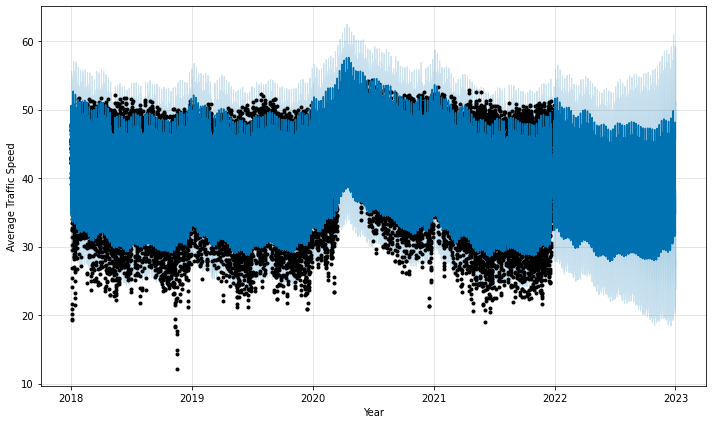

In [0]:
fig_trends = best_model.plot(df_forecast, xlabel='Year', ylabel='Average Traffic Speed')

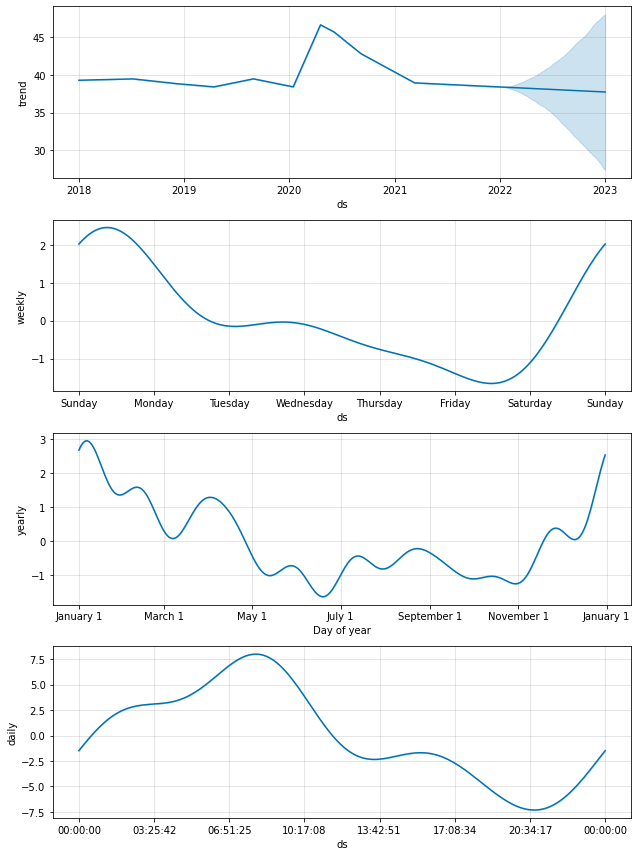

In [0]:
fig_components = best_model.plot_components(df_forecast)